# per-line transcription with LLM & OCR

In [1]:
from openai import OpenAI
from anthropic import Anthropic
import os
import re
import pandas as pd
from dotenv import load_dotenv
import requests
import base64
import subprocess
from IPython.display import display, Image
from PIL import Image as PILImage

In [2]:
import cv2
import easyocr
import matplotlib.pyplot as plt
import pytesseract
import keras_ocr

In [3]:
path = os.path.dirname(os.getcwd()) # Parent directory
image_folder = path+'/data/lines'

In [4]:
# OpenAI
load_dotenv() #get the environment 
openai_API_KEY = os.getenv("OPENAI_API_KEY")
openai_client = OpenAI(api_key=openai_API_KEY)

In [5]:
anthropic_API_KEY = os.getenv("ANTHROPIC_API_KEY")
anthropic_client = Anthropic(api_key=anthropic_API_KEY)
MODEL_NAME = "claude-3-5-sonnet-20240620"

## Read and encode the images

In [6]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [7]:
images = []
for image in os.listdir(image_folder):
    if image.endswith('.jpg'):
        images.append(image)

rows = []
for image in images:
    name = image.split('.')[0]
    name_split = name.split('_')[0]
    file_name = name_split.split('example')[1]
    line_name = name.split('_')[1]
    encoded_value = encode_image(image_folder+'/'+image)
    rows.append({'file': file_name, 'line': line_name, 'encoded': encoded_value})

images_encoded = pd.DataFrame(rows)

In [8]:
images_encoded['file'] = images_encoded['file'].astype('int')
images_encoded['line'] = images_encoded['line'].astype('int')
images_encoded = images_encoded.sort_values(by=['file', 'line']).reset_index(drop=True)
images_encoded['id'] = images_encoded['file'].astype(str) + '_' + images_encoded['line'].astype(str)
images_encoded.head(30)

,file,line,encoded,id
0,1,0,/9j/4QczRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_0
1,1,1,/9j/4QZBRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_1
2,1,2,/9j/4QX5RXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_2
3,1,3,/9j/4QYvRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_3
4,1,4,/9j/4QZLRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_4
5,1,5,/9j/4QVaRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_5
6,1,6,/9j/4QVqRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_6
7,1,7,/9j/4QX5RXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_7
8,1,8,/9j/4QWRRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_8
9,1,9,/9j/4QZyRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_9


# LLMs

## Zero-shot

In [9]:
prompt = """
    Recognize the text from the image:
    ```plaintext
"""


prompt_complex = """
    Context:
        It's an old Belgian document. And you're getting one row of a table from it. It's written in French language and the names of the people are domiciles are Belgian.

    Structure:
        The table is structured with the two-level headers as follows:
        [("N' d'ordre", " "),
                ("Date du dépot des déclarations", " "),
                ("Désignation des personnes décédées ou absentes.:", "Nom."),
                ("Désignation des personnes décédées ou absentes.:", "Prénoms"),
                ("Désignation des personnes décédées ou absentes.:", "Domiciles"), 
                ("Date du décès ou du judgement d'envoi en possession, en cas d'absence.", " "),
                ("Noms, Prénoms et demeures des parties déclarantes.", " "),
                ("Droits de succession en ligne collatérale et de mutation en ligne directe.", "Actif. (2)"),
                ("Droits de succession en ligne collatérale et de mutation en ligne directe.", "Passif. (2)"),
                ("Droits de succession en ligne collatérale et de mutation en ligne directe.", "Restant NET. (2)"),
                ("Droit de mutation par déces", "Valeur des immeubles. (2)"), 
                ("Numéros des déclarations", "Primitives."),
                ("Numéros des déclarations", "Supplémentaires."), 
                ("Date", "de l'expiration du délai de rectification."),
                ("Date", "de l'exigibilité des droits."),
                ("Numéros de la consignation des droits au sommier n' 28", " "),
                ("Recette des droits et amendes.", "Date"),
                ("Recette des droits et amendes.", "N^03"),
                ("Cautionnements. ", "Numéros de la consignation au sommier n'30"),
                ("Observations (les déclarations qui figurent à l'état n'413 doivent être émargées en conséquence, dans la présnete colonne.)", " ")] 

        Some image (hence, some rows) may start with "Arrêté le \d{2} \w+ \d{4}( \w+)? servais" or contain notes.

    Task:
        Recognize the text from the image. Pay attention to reading each word and number correctly. Return the text as you read it and you must read the text from the image since the image contains texts.
    ```plaintext 
"""

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
/var/folders/xy/r3gq5vtd7bx6qb966l0fhh9h0000gn/T/ipykernel_63694/818506988.py:7: SyntaxWarning: invalid escape sequence '\d'
  prompt_complex = """


In [10]:
def callOpenAI(prompt, max_tokens=800, base64_image=None):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_API_KEY}"
    } 
    model_vision = "gpt-4o"
    payload = {
        "model": model_vision, 
        "messages": [
        {
            "role": "system",
            "content": "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format."
            
        },
        {
            "role": "user",
            "content": [
            {
                "type": "text",
                "text": prompt
            },
            {
                "type": "image_url",
                "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
                }
            }
            ]
        }
        ],
        "max_tokens": max_tokens,
        "temperature": 0
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    try:
        return response.json()["choices"][0]["message"]["content"]
    except:
        print(response.json()["error"]["message"])

In [11]:
def callAnthropic(prompt, max_tokens=5000, base64_image=None):
    response = anthropic_client.messages.create(
        model=MODEL_NAME,
        max_tokens=max_tokens,
        system = "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format.",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "image", 
                        "source": {
                            "type": "base64", 
                            "media_type": "image/jpeg", 
                            "data": base64_image}},
                    {
                        "type": "text",
                        "text": prompt,
                    }
                ],
            }
        ],
        temperature=0,
    )
    return response.to_dict()["content"][0]["text"]

In [9]:
def callPostProcessing(max_tokens=800, prompt_parameter = None):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_API_KEY}"
    } 
    payload = {
        "model": "gpt-4o",
        "messages": [
        {
            "role": "user",
            "content": [
            {
                "type": "text",
                "text": f"""This is an output from you. Clean it such that we have no separators and no comment from you: {prompt_parameter}
                """
            }
            ]
        }
        ],
        "max_tokens": max_tokens,
        "temperature": 0
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    try:
        return response.json()["choices"][0]["message"]["content"]
    except:
        print(response.json()["error"]["message"])


### Zero-shot

In [19]:
import time
import json

# Load previous progress if available
try:
    with open('claude_complex_output_progress.json', 'r') as file:
        claude_complex_output = json.load(file)
except FileNotFoundError:
    claude_complex_output = {}

# Loop through each unique id
# for id in images_encoded['id'].unique():
for id in unable_ids_1:
    # Check if this ID is already processed (Skip this step if you want to re-process for unable_ids) ----------------
    # if id in claude_complex_output:
    #     print(f"Skipping {id}, already processed.")
    #     continue
    
    start_time = time.time()
    try:
        print(f'------- Start processing file {id} -------')
        
        # Call OpenAI/Anthropic and post-processing functions
        prompt_complex += "Even if it is hard to read the texts from the image, return as much as you can. You must read something. Do not return an apologetic message."
        # output = callOpenAI(prompt=prompt_complex, max_tokens=800, base64_image=images_encoded[(images_encoded['id'] == id)].encoded.values[0])
        output = callAnthropic(prompt=prompt_complex, max_tokens=800, base64_image=images_encoded[(images_encoded['id'] == id)].encoded.values[0])
        output_cleaned = callPostProcessing(prompt_parameter=output)
        
        # Save the output
        claude_complex_output[id] = output_cleaned
        
        # Save progress after each file
        with open('claude_complex_output_progress.json', 'w') as file:
            json.dump(claude_complex_output, file)
        
        print(f'------- Finished processing file {id} in {time.time() - start_time} seconds -------')

    except Exception as e:
        print(f"Error processing file {id}: {str(e)}")
        # Save the progress and exit the loop in case of an error
        with open('claude_complex_output_progress.json', 'w') as file:
            json.dump(claude_complex_output, file)
        break  # Exit the loop on error

# Once all IDs are processed, save the final result
with open('claude_complex_output_final.json', 'w') as file:
    json.dump(claude_complex_output, file)

print("Processing complete.")


------- Start processing file 6_1 -------
------- Finished processing file 6_1 in 4.5775532722473145 seconds -------
Processing complete.


### Few-shots

In [13]:
df = pd.read_csv(path+'/data/transcription_perline_text.csv')

In [10]:
example1 = images_encoded[images_encoded['id'] == '1_1'].encoded.values[0]
example2 = images_encoded[images_encoded['id'] == '1_2'].encoded.values[0]

In [11]:
images_encoded_oneshot = images_encoded[~images_encoded['id'].isin(['1_1'])]
images_encoded_twoshot = images_encoded[~images_encoded['id'].isin(['1_1', '1_2'])]

In [14]:
example1_text = df[df['id'] == '1_1'].text.values[0]
example2_text = df[df['id'] == '1_2'].text.values[0]

In [15]:
prompt_example =  """
    Recognize the texts from the image like the examples.
    ```plaintext
    """

In [16]:
def callAnthropic_example(prompt, example1, example2=None, NExample=1, base64_image=None, max_tokens=5000):
    if NExample == 1:
        response = anthropic_client.messages.create(
            model=MODEL_NAME,
            max_tokens=max_tokens,
            system = "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format.",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "image", 
                            "source": {
                                "type": "base64", 
                                "media_type": "image/jpeg", 
                                "data": example1}},
                        {
                            "type": "text",
                            "text": example1_text,
                        },
                        {
                            "type": "text",
                            "text": prompt,
                        },
                        {"type": "image", 
                            "source": {
                                "type": "base64", 
                                "media_type": "image/jpeg", 
                                "data": base64_image}}
                    ],
                }
            ],
            temperature=0,
        )
        
    if NExample == 2:
        response = anthropic_client.messages.create(
            model=MODEL_NAME,
            max_tokens=max_tokens,
            system = "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format.",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "image", 
                            "source": {
                                "type": "base64", 
                                "media_type": "image/jpeg", 
                                "data": example1}},
                        {
                            "type": "text",
                            "text": example1_text,
                        },
                        {"type": "image", 
                            "source": {
                                "type": "base64", 
                                "media_type": "image/jpeg", 
                                "data": example2}},
                        {
                            "type": "text",
                            "text": example2_text,
                        },
                        {
                            "type": "text",
                            "text": prompt,
                        },
                        {"type": "image", 
                            "source": {
                                "type": "base64", 
                                "media_type": "image/jpeg", 
                                "data": base64_image}}
                    ],
                }
            ],
            temperature=0,
        )
    return response.to_dict()["content"][0]["text"]

In [31]:
import time
import json

# Load previous progress if available
try:
    with open('claude_two_example_output_progress.json', 'r') as file:
        claude_two_example_output = json.load(file)
except FileNotFoundError:
    claude_two_example_output = {}

# Loop through each unique id
# for id in images_encoded_twoshot['id'].unique():
for id in unable_ids_3:
    # Check if this ID is already processed (Skip this step if you want to re-process for unable_ids) ----------------
    # if id in claude_two_example_output:
    #     print(f"Skipping {id}, already processed.")
    #     continue
    
    start_time = time.time()
    try:
        print(f'------- Start processing file {id} -------')
        
        # Call OpenAI/Anthropic and post-processing functions
        prompt_example += "Even if it is hard to read the texts from the image, return as much as you can. You must read something. Do not return an apologetic message."
        # output = callOpenAI(prompt=prompt_complex, max_tokens=800, base64_image=images_encoded[(images_encoded['id'] == id)].encoded.values[0])
        output = callAnthropic_example(prompt=prompt_example, example1=example1, example2=example2, NExample=2, base64_image=images_encoded_twoshot[(images_encoded_twoshot['id'] == id)].encoded.values[0], max_tokens=800)
        output_cleaned = callPostProcessing(prompt_parameter=output)
        
        # Save the output
        claude_two_example_output[id] = output_cleaned
        
        # Save progress after each file
        with open('claude_two_example_output_progress.json', 'w') as file:
            json.dump(claude_two_example_output, file)
        
        print(f'------- Finished processing file {id} in {time.time() - start_time} seconds -------')

    except Exception as e:
        print(f"Error processing file {id}: {str(e)}")
        # Save the progress and exit the loop in case of an error
        with open('claude_two_example_output_progress.json', 'w') as file:
            json.dump(claude_two_example_output, file)
        break  # Exit the loop on error

# Once all IDs are processed, save the final result
with open('claude_two_example_output_final.json', 'w') as file:
    json.dump(claude_two_example_output, file)

print("Processing complete.")


------- Start processing file 3_0 -------
------- Finished processing file 3_0 in 15.610320806503296 seconds -------
------- Start processing file 9_0 -------
------- Finished processing file 9_0 in 9.42707109451294 seconds -------
Processing complete.


### Outputs

In [32]:
claude_two_example_output

{'1_0': 'arrêté le vingt huit octobre 1919 servais arrêté le vingt neuf octobre 1919 servais',
 '1_3': '398 trente Herrent Alphonse orphelin 1892 à 13 Herrent Marie & autres octobre 2280 1085 1195 11 29/30 15 9/30 1919 feuillet 365',
 '1_4': '398e Lefevre Jules Brasseur Jemappes Nicolle Amélie xxxx xxxx 241 célibat. 1919',
 '1_5': 'Arrêté le vingt huit octobre 1919 servais',
 '1_6': 'Arrêté le vingt huit octobre 1919 servais',
 '1_7': 'Arrêté le premier novembre 1919 Toussaint Servais',
 '1_8': 'Arrêté le deux novembre 1919 Dimanche servais',
 '1_9': '399 bras g[ère] Desmedt Jeanne Nivelles 13 mai 2020 décédée Célibataire 9410 520 39 10 15 38/99 13 mars 10 février 35 1919 1921 1920',
 '1_10': '400 Monseur Pascal Henri Edouard 1 8bre 1918 Sergent Soldat 690.00 344.78 344.78 58 28 4 avril 1919',
 '1_11': '401 d Bouty Henri Décédé le 20 février Bouty Marie Père 2574 2574 15 d 20 fév 1919 non passible 1919',
 '1_12': 'Arrêté le trois novembre 1919 servais',
 '1_13': '402 Hubert Vve Godart 

In [30]:
unable_ids_3 = [id for id, content in claude_two_example_output.items() if "The image" in content or "I apologize" in content]
print(unable_ids_3, len(unable_ids_3), sep='\n')

['3_0', '9_0']
2


### To run with the saved json

In [38]:
claude_two_example_output_df = pd.DataFrame(claude_two_example_output.items(), columns=['id', 'content'])
# gpt_complex_output_df = pd.DataFrame(gpt_complex_output.items(), columns=['id', 'content'])

In [39]:
# claude_output_df['content'] = claude_output_df['content'].replace(['\n', '\t'], ' ', regex=True)
claude_two_example_output_df['content'] = claude_two_example_output_df['content'].replace(['\n', '\t'], ' ', regex=True)
claude_two_example_output_df

,id,content
0,1_0,arrêté le vingt huit octobre 1919 servais arrê...
1,1_3,398 trente Herrent Alphonse orphelin 1892 à 13...
2,1_4,398e Lefevre Jules Brasseur Jemappes Nicolle A...
3,1_5,Arrêté le vingt huit octobre 1919 servais
4,1_6,Arrêté le vingt huit octobre 1919 servais
...,...,...
276,20_9,arrêté le vingt huit octobre 1919 servais arrê...
277,20_10,Dubois Alexandre épicerie 1er 1919 décédé Jean...
278,20_11,Arrêté le dix neuf février 1920 servais
279,20_12,Arrêté le vingt neuf octobre 1919 servais


In [40]:
# claude_output_df.rename(columns={'content': 'text'}, inplace=True) #To ensure the same column name as df below.
claude_two_example_output_df.rename(columns={'content': 'text'}, inplace=True)

In [41]:
# claude_output_df.to_csv(path+'/results/postprocessed/claude_perline_output.csv', index=False)
claude_two_example_output_df.to_csv(path+'/results/postprocessed/claude_two_example_perline_output.csv', index=False)

## CER/BLEU calculation

## ground truth df

In [110]:
from glob import glob

text_path = path+'/data/transcriptions'
file_list = glob(os.path.join(text_path, 'transcription_ex*.txt'))

df_list = []

for file in file_list:
    with open(file, 'r', encoding='utf-8') as f:
        content = f.read()
    lines = content.split('\n')

    df = pd.DataFrame({
        'line': range(0, len(lines)),  # Line numbers starting from 0
        'text': lines
    })
    
    name = os.path.basename(file)
    name = name.split('.')[0]
    df['file'] = name.split('ex')[1]
    df['file'] = df['file'].astype(int)
    df_list.append(df)
df = pd.concat(df_list, ignore_index=True)

In [111]:
df['text'] = df['text'].replace(['\n', '\t'], ' ', regex=True)
df = df.sort_values(by=['file', 'line']).reset_index(drop=True)
df

,line,text,file
0,0,N' d'ordre Date du dépot des déclarations Dési...,1
1,1,Nom. Prénoms Domiciles Actif. (2) Passif. (2) ...,1
2,2,arrêté le vingt huit octobre 1919 servais ...,1
3,3,arrêté le vingt neuf octobre 1919 servais ...,1
4,4,398 trente octobre Herrent Alphones gh Ophain ...,1
...,...,...,...
298,10,19 dix neuf d Pétriaux Coralie Nivelles 22 av...,20
299,11,19^2 d Dubois Alexandre Quenast 7b 1919 Dubois...,20
300,12,Arrêté le dix neuf février 1920 servais,20
301,13,Arrêté le vingt février 1920 servais,20


In [112]:
# Merge the text values of line number 0 and 1 (the two lines of the header)
for file in df['file'].unique():
    header_lines = df[(df['file'] == file) & (df['line'].isin([0, 1]))]
    df.loc[header_lines.index[0], 'text'] = header_lines.iloc[0]['text'] + " " + header_lines.iloc[1]['text']
df = df[df['line'] != 1].reset_index(drop=True)

In [113]:
df.loc[df['line'] != 0, 'line'] -= 1  # Adjust line numbers after removing the second line of the header

In [30]:
# # for file 6, two lines are used for some column.. we need to merge them
# doubled_line = df[(df['file'] == 6) & (df['line'].isin([3, 4]))]
# df.loc[doubled_line.index[0], 'text'] = doubled_line.iloc[0]['text'] + " " + doubled_line.iloc[1]['text']
# df.drop(doubled_line.index[1], inplace=True)
# df.loc[(df['file'] == 6) & (df['line'] > 4), 'line'] -= 1


In [114]:
df[df['file']==1]

,line,text,file
0,0,N' d'ordre Date du dépot des déclarations Dési...,1
1,1,arrêté le vingt huit octobre 1919 servais ...,1
2,2,arrêté le vingt neuf octobre 1919 servais ...,1
3,3,398 trente octobre Herrent Alphones gh Ophain ...,1
4,4,398^2 d Lefévre Jules Braine l'Alleud 8 Janvie...,1
5,5,arrêté le trente octobre 1919 servais ...,1
6,6,arrêté le trente un octobre 1919 servais ...,1
7,7,arrêté le premier novembre 1919 Toussaint ser...,1
8,8,arrêté le deux novembre 1919 Dimanche servais...,1
9,9,399 trois 9bre Desmedt Jeanne Nivelles 13 mai ...,1


In [115]:
df['id'] = df['file'].astype(str) + '_' + df['line'].astype(str)
df

,line,text,file,id
0,0,N' d'ordre Date du dépot des déclarations Dési...,1,1_0
1,1,arrêté le vingt huit octobre 1919 servais ...,1,1_1
2,2,arrêté le vingt neuf octobre 1919 servais ...,1,1_2
3,3,398 trente octobre Herrent Alphones gh Ophain ...,1,1_3
4,4,398^2 d Lefévre Jules Braine l'Alleud 8 Janvie...,1,1_4
...,...,...,...,...
278,9,19 dix neuf d Pétriaux Coralie Nivelles 22 av...,20,20_9
279,10,19^2 d Dubois Alexandre Quenast 7b 1919 Dubois...,20,20_10
280,11,Arrêté le dix neuf février 1920 servais,20,20_11
281,12,Arrêté le vingt février 1920 servais,20,20_12


In [116]:
for file in df['file'].unique():
    last_line = df[df['file'] == file]['line'].max()
    print(f"File: {file}, Last Line: {last_line}")

File: 1, Last Line: 13
File: 2, Last Line: 14
File: 3, Last Line: 13
File: 4, Last Line: 13
File: 5, Last Line: 14
File: 6, Last Line: 14
File: 7, Last Line: 13
File: 8, Last Line: 13
File: 9, Last Line: 13
File: 10, Last Line: 13
File: 11, Last Line: 13
File: 12, Last Line: 13
File: 13, Last Line: 13
File: 14, Last Line: 13
File: 15, Last Line: 13
File: 16, Last Line: 13
File: 17, Last Line: 13
File: 18, Last Line: 13
File: 19, Last Line: 13
File: 20, Last Line: 13


In [117]:
df.to_csv(path+'/data/transcription_perline_text.csv', index=False)

In [88]:
print(df['id'].nunique(), claude_output_df['id'].nunique())

283 283


## Calculate

In [42]:
df = pd.read_csv(path+'/data/transcription_perline_text.csv')

In [43]:
from evaluate import load

cer_metric =load("cer")
bleu_metric = load("bleu")  

In [44]:
df_two_example = df[~df['id'].isin(['1_1', '1_2'])]

In [45]:
bleu_gpt = {}
cer_gpt = {}

for id in df_two_example['id'].unique():
    # Extract the text as a single string, not as an array
    pred_text = claude_two_example_output_df[claude_two_example_output_df['id'] == id]['text'].values[0]
    ref_text = df_two_example[df_two_example['id'] == id]['text'].values[0]

    # Ensure the predictions and references are passed as a list of strings
    if pred_text and ref_text:  # Check if both texts are not empty (which happens for some OCR outputs)
        bleu_gpt[id] = bleu_metric.compute(predictions=[pred_text], references=[ref_text])
    else:
        bleu_gpt[id] = {'bleu': 0.0}  # Assign a default value if texts are empty
    cer_gpt[id] = cer_metric.compute(predictions=[pred_text], references=[ref_text])


In [46]:
bleu_gpt = pd.DataFrame(bleu_gpt).T

In [47]:
print(bleu_gpt['bleu'].mean(), bleu_gpt['bleu'].var())

0.19889237491495051 0.12344114482244997


In [48]:
bleu_gpt['id'] = bleu_gpt.index
bleu_gpt

,bleu,precisions,brevity_penalty,length_ratio,translation_length,reference_length,id
1_0,0.0,"[0.0, 0.0, 0.0, 0.0]",0.000052,0.092105,14,152,1_0
1_3,0.0,"[0.4074074074074074, 0.07692307692307693, 0.0,...",1.0,1.0,27,27,1_3
1_4,0.0,"[0.15384615384615385, 0.0, 0.0, 0.0]",0.680712,0.722222,13,18,1_4
1_5,0.0,"[0.5714285714285714, 0.3333333333333333, 0.2, ...",1.0,1.166667,7,6,1_5
1_6,0.0,"[0.5714285714285714, 0.3333333333333333, 0.2, ...",1.0,1.0,7,7,1_6
...,...,...,...,...,...,...,...
20_9,0.0,"[0.38235294117647056, 0.18181818181818182, 0.0...",1.0,1.478261,34,23,20_9
20_10,0.0,"[0.6, 0.2857142857142857, 0.0, 0.0]",0.627089,0.681818,15,22,20_10
20_11,1.0,"[1.0, 1.0, 1.0, 1.0]",1.0,1.0,7,7,20_11
20_12,0.0,"[0.5714285714285714, 0.3333333333333333, 0.2, ...",1.0,1.166667,7,6,20_12


In [49]:
bleu_gpt['file'] = bleu_gpt['id'].str.split('_').str[0].astype(int)
bleu_gpt.groupby('file')['bleu'].agg(['mean', 'var'])

,mean,var
file,,
1,0.211815,0.103317
2,0.227095,0.16519
3,0.220729,0.136279
4,0.120822,0.082747
5,0.133333,0.12381
6,0.139682,0.092045
7,0.253671,0.123574
8,0.094875,0.026633
9,0.175183,0.12608


In [50]:
bleu_gpt.to_csv(path+'/results/scores_comparisons/bleu_claude_two_example_perline.csv')

In [51]:
cer_gpt = pd.DataFrame(cer_gpt.items(), columns=['id', 'cer'])

In [52]:
print(cer_gpt['cer'].mean(), cer_gpt['cer'].var())

0.5717437322276548 2.9350976770440713


In [53]:
cer_gpt.to_csv(path+'/results/scores_comparisons/cer_claude_two_example_perline.csv')

In [54]:
cer_gpt['file'] = cer_gpt['id'].str.split('_').str[0].astype(int)
cer_gpt.groupby('file')['cer'].agg(['mean', 'var'])

,mean,var
file,,
1,0.356951,0.070660
2,0.362893,0.066101
3,0.640825,1.133851
4,0.523756,0.553484
5,1.871461,24.655433
6,1.693562,25.706980
7,0.252826,0.071676
8,0.558813,0.306911
9,0.225097,0.085403


# OCR

## EasyOCR

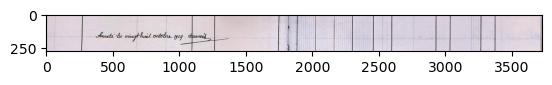

In [148]:
test_image = cv2.imread(test_path)
plt.imshow(test_image)

In [128]:
def easyOCR(image_path):
    reader = easyocr.Reader(['fr'])
    img = cv2.imread(image_path)
    results = reader.readtext(img)
    output = []
    for res in results:
        det, conf = res[1], res[2]
        output.append((det, round(conf, 2))) 
    text = ' '.join([i[0] for i in output])
    return text

In [129]:
easyOCR_output = {}
for image in os.listdir(image_folder):
    if image.endswith('.jpg'):
        image_path = image_folder + '/' + image
        text = easyOCR(image_path)
        name = image.split('.')[0]
        name = name.split('example')[1]
        easyOCR_output[name] = text

In [43]:
# easyOCR_output_df = pd.read_csv(path+'/results/postprocessed/easyOCR_perline_output.csv')
easyOCR_output_df

,file,text,file_name,line_name,id
0,1_00,DÉSIGNATION DES PERSONNES DÉCÉDÉES OU AlSENTES...,1,0,1_0
1,1_01,~Bcrta` 8 oetolz 1919 d4earuey vicytAul,1,1,1_1
2,1_02,Jbsucala & veyhmeuf ouoba tg19 [eevœy,1,2,1_2
3,1_03,891 ta HBevcenk ~Bepkonssjk oj hain Hgoucoal Y...,1,3,1_3
4,1_04,"TulL Bouuù Q ""Janer ~aobà Bhuile RRXR 26 aplul...",1,4,1_4
...,...,...,...,...,...
278,20_09,J9 ùcà nuf> Sebiaw bo2nbi YÉvepQu X anel Bebel...,20,9,20_9
279,20_10,4 49 0 : @ubovs ssexanbz Yuemaut ubuùd *ean [l...,20,10,20_10
280,20_11,Jvuté & oi = neuf fasles19:0 Huclai,20,11,20_11
281,20_12,Jarsalé - vms] Hinsenq %0 djeceia |,20,12,20_12


In [136]:
easyOCR_output_df = pd.DataFrame(easyOCR_output.items(), columns=['file', 'text'])
easyOCR_output_df[['file_name', 'line_name']] = easyOCR_output_df['file'].str.split('_', expand=True)
easyOCR_output_df[['file_name', 'line_name']] = easyOCR_output_df[['file_name', 'line_name']].astype(int)
easyOCR_output_df = easyOCR_output_df.sort_values(by=['file_name', 'line_name']).reset_index(drop=True)
easyOCR_output_df['text'] = easyOCR_output_df['text'].replace(['\n', '\t'], ' ', regex=True)
easyOCR_output_df['id'] = easyOCR_output_df['file_name'].astype(str) + '_' + easyOCR_output_df['line_name'].astype(str)
easyOCR_output_df

,file,text
0,10_00,DATE I IÉcis DROITS DF SUCCESSION DROIT NUMÉRO...
1,10_01,soceti & tù déeemebza. 919 Yuepiy
2,10_02,5 1439 DaLenlize Yiceppu #9lugu | Benuue YLama...
3,10_03,Jaxat' € deeemlaac919 Fuupùa quebu
4,10_04,[4ho ceæy _ (ekalque Pnag;nl Yjuuy Wv&ezlbz (...
...,...,...
278,9_09,69*2.4 Scinllane Pots+a Gxz9& SasBBoe Gpmzeyen...
279,9_10,"kag' 0: Sainllane Bwun' à 26r' 1sr ""9"
280,9_11,Joaak + fnmauu dceehu 1919 Yeoeok
281,9_12,[4Jg %eu 3- CBaslice fe At Z8ma 2e+eygu | Jwti...


In [44]:
easyOCR_output_df.to_csv(path+'/results/postprocessed/easyOCR_perline_output.csv', index=False)

### Pytesseract

In [10]:
def pytesseractOCR(image_path):
    try:
        image = PILImage.open(image_path)
        text = pytesseract.image_to_string(image)
        return text
    except:
        print("[ERROR] pytesseractOCR failed! (should be installed)")
        return ""

In [11]:
pytesseractOCR_output = {}
for image in os.listdir(image_folder):
    if image.endswith('.jpg'):
        image_path = image_folder + '/' + image
        text = pytesseractOCR(image_path)
        name = image.split('.')[0]
        name = name.split('example')[1]
        pytesseractOCR_output[name] = text

In [55]:
pytesseractOCR_output_df = pd.DataFrame(pytesseractOCR_output.items(), columns=['file', 'text'])
pytesseractOCR_output_df[['file_name', 'line_name']] = pytesseractOCR_output_df['file'].str.split('_', expand=True)
pytesseractOCR_output_df[['file_name', 'line_name']] = pytesseractOCR_output_df[['file_name', 'line_name']].astype(int)
pytesseractOCR_output_df = pytesseractOCR_output_df.sort_values(by=['file_name', 'line_name']).reset_index(drop=True)
pytesseractOCR_output_df['text'] = pytesseractOCR_output_df['text'].replace(['\n', '\t'], ' ', regex=True)
pytesseractOCR_output_df['id'] = pytesseractOCR_output_df['file_name'].astype(str) + '_' + pytesseractOCR_output_df['line_name'].astype(str)
pytesseractOCR_output_df

,file,text,file_name,line_name,id
0,1_00,| = | DATE DU DEPOT des DECLARATIONS. DESI...,1,0,1_0
1,1_01,ft alt alta,1,1,1_1
2,1_02,,1,2,1_2
3,1_03,a cnte |Abevcenk a dette Son <a 1040’ i ee ...,1,3,1_3
4,1_04,L 3 be oi 7 Nf »- p,1,4,1_4
...,...,...,...,...,...
278,20_09,149 28 auf Si elaiawx Ve | | Wvebly eu ty ...,20,9,20_9
279,20_10,; a : oe ssa song o Sannin nomena ie 3 (0....,20,10,20_10
280,20_11,| aul,20,11,20_11
281,20_12,Caen torah Winéorg ty dieser’ es oe aaa. pa...,20,12,20_12


In [56]:
pytesseractOCR_output_df.to_csv(path+'/results/postprocessed/pytesseractOCR_perline_output.csv', index=False)

### Keras

Not good for non-english?

In [139]:
def kerasOCR(image_path):
    pipeline = keras_ocr.pipeline.Pipeline()
    image = keras_ocr.tools.read(image_path)
    prediction_groups = pipeline.recognize([image])
    words = []
    for line in prediction_groups[0]:
        for word in line:
            try:
                if isinstance(word[0], str):
                    words.append(word[0])
            except IndexError:
                continue
    text = ' '.join(words)
    return text

In [140]:
kerasOCR_output = {}
for image in os.listdir(image_folder):
    if image.endswith('.jpg'):
        image_path = image_folder + '/' + image
        text = kerasOCR(image_path)
        name = image.split('.')[0]
        name = name.split('example')[1]
        kerasOCR_output[name] = text

Looking for /Users/serenekim/.keras-ocr/craft_mlt_25k.h5


ValueError: Unrecognized keyword arguments passed to Dense: {'weights': [array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32), array([1., 0., 0., 0., 1., 0.], dtype=float32)]}

In [173]:
test_keras = kerasOCR(image_path=test_path)
print(test_keras)

Looking for /Users/serenekim/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.
Looking for /Users/serenekim/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 751ms/step
d r p o a g


# Pipeline

In [113]:
gpt4o_texts = []
easyOCR_texts = []
# pytesseract_texts = []
# kerasOCR_texts = []

# for file in images_encoded['file'].unique():
for file in [1]:
    print(f"File: {file}")
    for line in images_encoded[images_encoded['file'] == file]['line']:
        print(f"Line: {line}")
        image_path = image_folder+f'/example{file}_{line}.jpg'
        input_encoded_image = images_encoded[(images_encoded['file'] == file) & (images_encoded['line'] == line) ]['encoded'].values[0]
        
###### GPT-4o
        line_text_gpt4o = callOpenAI(prompt=prompt, max_tokens=800, base64_image = input_encoded_image)
        # print(f"OpenAI: {line_text_gpt4o}")
        postprocessed_gpt40_text = callPostProcessing(max_tokens=800, prompt_parameter = line_text_gpt4o)
        gpt4o_texts.append({'file': file, 'line': line, 'gpt4o_text': postprocessed_gpt40_text})
        line_text_complex = callOpenAI(prompt=prompt_complex, max_tokens=800, base64_image = input_encoded_image)
        print(f"OpenAI Complex: {line_text_complex}")

###### EasyOCR
        line_text_easyOCR = easyOCR(image_path)
    # Question: Will I need to postprocess the EasyOCR text?
        easyOCR_texts.append({'file': file, 'line': line, 'easyOCR_text': line_text_easyOCR})
        # print(f"EasyOCR: {line_text_easyOCR}")

###### Pytesseract
        # line_text_pytesseract = pytesseractOCR(image_path)
        # print(f"Pytesseract: {line_text_pytesseract}")

###### KerasOCR
        # line_text_keras = kerasOCR(image_path)
        # kerasOCR_texts.append({'file': file, 'line': line, 'kerasOCR_text': line_text_keras})
        # print(f"KerasOCR: {line_text_keras}")

gpt4o_texts_df = pd.DataFrame(gpt4o_texts)
easyOCR_texts_df = pd.DataFrame(easyOCR_texts)

File: 1
Line: 00
OpenAI Complex: Here is the transcribed text from the image:

```
N° d'ordre (1) | DATE DU DÉPÔT des DÉCLARATIONS. | DÉSIGNATION DES PERSONNES DÉCÉDÉES, OU ABSENTES. | DATE DU DÉCÈS ou du JUGEMENT D'ENVOI en possession, en cas d'absence. | NOMS, PRÉNOMS ET DEMEURES DES PARTIES DÉCLARANTES. | DROITS DE SUCCESSION EN LIGNE COLLATERALE et de MUTATION EN LIGNE DIRECTE. | DROIT DE MUTATION par décès. | NUMÉROS des DÉCLARATIONS | DATE de l'exigibilité des droits. | NUMÉROS de la consignation des droits au somnier n° 25. | RECETTE des DROITS ET AMENDES. | DATE | N° | CAUTIONNEMENTS. NUMÉROS de la consignation au somnier n° 30. | OBSERVATIONS. (Les déclarations qui figurent à l'état n° 11 doivent être énoncées en exécution, dans la présente colonne.)
```

This transcription captures the headers of the columns in the document.
Line: 01
OpenAI Complex: The text in the image reads:

"Arrêté le vingt huit octobre 1919 servais"
Line: 02
OpenAI Complex: The text in the image reads:


In [114]:
gpt4o_texts_df

,file,line,gpt4o_text
0,1,00,N° d'ordre\nDATE DU DÉPÔT des DÉCLARATIONS\nDÉ...
1,1,01,Societé le vingt huit octobre 1919
2,1,02,Arrêté le vingt neuf octobre 1919 Servais
3,1,03,398 treinte octubre Herrero Alphonse Opheim 29...
4,1,04,398½ d Lefèvre Jules Brulé-L. 8 janvier ...
5,1,05,Avant le trente octobre 1919
6,1,06,Soresti le trent un octob 1929 Servais
7,1,07,Sorreté le premier novembre 1919 Toussaint Ser...
8,1,08,Arresté le deux novembre 1919 Dimanche Servais
9,1,09,```\n399 Crois. 6bre. Desmedt Jeanne Nivelles ...


In [115]:
easyOCR_texts_df

,file,line,easyOCR_text
0,1,00,DÉSIGNATION DES PERSONNES DÉCÉDÉES OU AlSENTES...
1,1,01,~Bcrta` 8 oetolz 1919 d4earuey vicytAul
2,1,02,Jbsucala & veyhmeuf ouoba tg19 [eevœy
3,1,03,891 ta HBevcenk ~Bepkonssjk oj hain Hgoucoal Y...
4,1,04,"TulL Bouuù Q ""Janer ~aobà Bhuile RRXR 26 aplul..."
5,1,05,sueb' Q {cmEE oclb. 1419 dqune
6,1,06,Jsveaki @ bemlL un oelba_-1919 dexl'
7,1,07,kszeté & fummlar nouembas_ 1919 ollsaams Vuser...
8,1,08,Joveal + Jeunx 2ouemba (949 Oùhanebe Fuuunù/
9,1,09,889 644 (esmedk Yenooz Yiveblu 43 m22 euupsek ...
